In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Function to load data from multiple CSV files
def load_data(dataset_files):
    combined_data = []
    for file in dataset_files:
        participant_data = pd.read_csv(file)
        combined_data.append(participant_data)
    return pd.concat(combined_data, ignore_index=True)

# Function to split data by participant for age and gender models
def train_test_split_by_participant(data, test_size=0.2):
    participants = data['Participant'].unique()
    np.random.shuffle(participants)
    test_size = int(len(participants) * test_size)
    test_participants = participants[-test_size:]
    train_participants = participants[:-test_size]

    train_data = data[data['Participant'].isin(train_participants)]
    test_data = data[data['Participant'].isin(test_participants)]

    # Detailed split information
    print("Training on participants from databases:\n", train_data[['Participant', 'Database']].drop_duplicates())
    print("Testing on participants from databases:\n", test_data[['Participant', 'Database']].drop_duplicates())
    return train_data, test_data

# Function to perform time-series split for participant ID identification
def time_series_split(data, test_ratio=0.2):
    train_data = data.groupby('Participant').apply(lambda x: x.iloc[:int(len(x)*(1-test_ratio))]).reset_index(drop=True)
    test_data = data.groupby('Participant').apply(lambda x: x.iloc[int(len(x)*(1-test_ratio)):]).reset_index(drop=True)

    # Detailed split information
    for participant, group in data.groupby('Participant'):
        train_end = int(len(group)*(1-test_ratio))
        print(f"Participant {participant} from {group['Database'].iloc[0]}: Train indices 0 to {train_end}, Test indices {train_end} to {len(group)}")
    return train_data, test_data

# Function to prepare features and labels for training
def prepare_features_labels(data, label_column, encode=True):
    features = data.drop(columns=['Participant', 'Sample', 'Sampling_Rate', 'Database', 'Gender', 'Age', 'age_binned'])
    labels = data[label_column]
    if encode:
        encoder = LabelEncoder()
        labels = encoder.fit_transform(labels)
    return features, labels

# Main experiment setup
dataset_paths = [
    'mit-bih_ECGs.csv',
    'mit-long_ECGs.csv',
    'smart_ECGs.csv',
    'chfdb_ECGs.csv',
    'brno_ECGs.csv'
]

combined_data = load_data(dataset_paths)

# Drop the 'Half Minute' column if it exists
if 'Half Minute' in combined_data.columns:
    combined_data = combined_data.drop(columns=['Half Minute'])

# Replace 'm' with 'M' in Gender column
combined_data['Gender'] = combined_data['Gender'].replace({'m': 'M'})

# Drop any rows with NaN values
combined_data = combined_data.dropna()

# Define age bins and labels
age_bins = [0, 18, 35, 50, 65, 80, 100]
age_labels = [f"{age_bins[i]}-{age_bins[i+1]}" for i in range(len(age_bins)-1)]

# Bin the ages and encode the bins
combined_data['age_binned'] = pd.cut(combined_data['Age'], bins=age_bins, labels=age_labels, right=False)
le = LabelEncoder()
combined_data['age_binned'] = le.fit_transform(combined_data['age_binned'])

# Splitting data for age and gender identification
train_data_ag, test_data_ag = train_test_split_by_participant(combined_data, test_size=0.2)

# Preparing features and labels for Gender identification
X_train_gender, y_train_gender = prepare_features_labels(train_data_ag, 'Gender')
X_test_gender, y_test_gender = prepare_features_labels(test_data_ag, 'Gender')

# Preparing features and labels for Age identification
X_train_age, y_train_age = prepare_features_labels(train_data_ag, 'age_binned')
X_test_age, y_test_age = prepare_features_labels(test_data_ag, 'age_binned')

# Time-series split for Participant ID identification
train_data_id, test_data_id = time_series_split(combined_data, test_ratio=0.2)
X_train_id, y_train_id = prepare_features_labels(train_data_id, 'Participant', encode=False)
X_test_id, y_test_id = prepare_features_labels(test_data_id, 'Participant', encode=False)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import shap

def evaluate_model(model, X_test, y_test, task):
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=1) if predictions.shape[1] > 1 else (predictions > 0.5).astype("int32")
    true_classes = y_test if y_test.ndim == 1 else np.argmax(y_test, axis=1)

    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average='weighted')
    recall = recall_score(true_classes, predicted_classes, average='weighted')
    f1 = f1_score(true_classes, predicted_classes, average='weighted')
    roc_auc = roc_auc_score(y_test, predictions, multi_class='ovr') if y_test.ndim > 1 else roc_auc_score(y_test, predictions)

    print(f"\n--- {task} ---")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)

    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(f'Confusion Matrix for {task}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # # SHAP analysis (for interpretability)
    # explainer = shap.Explainer(model, X_test)
    # shap_values = explainer(X_test)
    # shap.summary_plot(shap_values, X_test, plot_type="bar")


Training on participants from databases:
           Participant  Database
0          mit-bih_00   mit-bih
650000     mit-bih_01   mit-bih
1300000    mit-bih_02   mit-bih
1950000    mit-bih_03   mit-bih
2600000    mit-bih_04   mit-bih
3250000    mit-bih_05   mit-bih
3707859   mit-long_00  mit-long
4629459   mit-long_01  mit-long
5551059   mit-long_02  mit-long
6010137      smart_00     smart
6931737      smart_01     smart
9212190      chfdb_01     chfdb
11012190     chfdb_02     chfdb
12812190     chfdb_03     chfdb
14612190     chfdb_04     chfdb
18212190     chfdb_06     chfdb
21812190     chfdb_08     chfdb
23944795      brno_00      brno
31144795      brno_01      brno
Testing on participants from databases:
          Participant Database
7412190     chfdb_00    chfdb
16412190    chfdb_05    chfdb
20012190    chfdb_07    chfdb
23612190    chfdb_09    chfdb


/tmp/ipykernel_952288/3279442143.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_data = data.groupby('Participant').apply(lambda x: x.iloc[:int(len(x)*(1-test_ratio))]).reset_index(drop=True)
/tmp/ipykernel_952288/3279442143.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_data = data.groupby('Participant').apply(lambda x: x.iloc[int(len(x)*(1-test_ratio)):]).reset_index(drop=True)


Participant brno_00 from brno: Train indices 0 to 5760000, Test indices 5760000 to 7200000
Participant brno_01 from brno: Train indices 0 to 5102570, Test indices 5102570 to 6378213
Participant chfdb_00 from chfdb: Train indices 0 to 1440000, Test indices 1440000 to 1800000
Participant chfdb_01 from chfdb: Train indices 0 to 1440000, Test indices 1440000 to 1800000
Participant chfdb_02 from chfdb: Train indices 0 to 1440000, Test indices 1440000 to 1800000
Participant chfdb_03 from chfdb: Train indices 0 to 1440000, Test indices 1440000 to 1800000
Participant chfdb_04 from chfdb: Train indices 0 to 1440000, Test indices 1440000 to 1800000
Participant chfdb_05 from chfdb: Train indices 0 to 1440000, Test indices 1440000 to 1800000
Participant chfdb_06 from chfdb: Train indices 0 to 1440000, Test indices 1440000 to 1800000
Participant chfdb_07 from chfdb: Train indices 0 to 1440000, Test indices 1440000 to 1800000
Participant chfdb_08 from chfdb: Train indices 0 to 1440000, Test indices 

Using device: cuda


Training Epoch 1/20: 100%|██████████| 83/83 [04:38<00:00,  3.36s/it]


Epoch [1/20], Training Loss: 0.5513


Validation - Epoch [1/20] Metrics:
Accuracy: 0.7148, Precision: 0.6273, Recall: 0.9984, F1 Score: 0.7705, ROC AUC: 0.7258, Loss: 0.5080
Model saved with validation accuracy: 0.7148


Training Epoch 2/20: 100%|██████████| 83/83 [04:41<00:00,  3.40s/it]


Epoch [2/20], Training Loss: 0.5043


Validation - Epoch [2/20] Metrics:
Accuracy: 0.7186, Precision: 0.6331, Recall: 0.9831, F1 Score: 0.7702, ROC AUC: 0.7289, Loss: 0.5009
Model saved with validation accuracy: 0.7186


Training Epoch 3/20: 100%|██████████| 83/83 [04:40<00:00,  3.38s/it]


Epoch [3/20], Training Loss: 0.4996


Validation - Epoch [3/20] Metrics:
Accuracy: 0.7212, Precision: 0.6410, Recall: 0.9518, F1 Score: 0.7661, ROC AUC: 0.7302, Loss: 0.4990
Model saved with validation accuracy: 0.7212


Training Epoch 4/20: 100%|██████████| 83/83 [04:41<00:00,  3.39s/it]


Epoch [4/20], Training Loss: 0.4985


Validation - Epoch [4/20] Metrics:
Accuracy: 0.7196, Precision: 0.6420, Recall: 0.9388, F1 Score: 0.7625, ROC AUC: 0.7281, Loss: 0.4976


Training Epoch 5/20: 100%|██████████| 83/83 [04:40<00:00,  3.38s/it]


Epoch [5/20], Training Loss: 0.4969


Validation - Epoch [5/20] Metrics:
Accuracy: 0.7185, Precision: 0.6431, Recall: 0.9282, F1 Score: 0.7598, ROC AUC: 0.7267, Loss: 0.4961


Training Epoch 6/20: 100%|██████████| 83/83 [04:40<00:00,  3.38s/it]


Epoch [6/20], Training Loss: 0.4959


Validation - Epoch [6/20] Metrics:
Accuracy: 0.7186, Precision: 0.6433, Recall: 0.9277, F1 Score: 0.7598, ROC AUC: 0.7268, Loss: 0.4957


Training Epoch 7/20: 100%|██████████| 83/83 [04:40<00:00,  3.38s/it]


Epoch [7/20], Training Loss: 0.4957


Validation - Epoch [7/20] Metrics:
Accuracy: 0.7190, Precision: 0.6431, Recall: 0.9306, F1 Score: 0.7606, ROC AUC: 0.7273, Loss: 0.4956


Training Epoch 8/20: 100%|██████████| 83/83 [04:42<00:00,  3.41s/it]


Epoch [8/20], Training Loss: 0.4956


Validation - Epoch [8/20] Metrics:
Accuracy: 0.7190, Precision: 0.6430, Recall: 0.9309, F1 Score: 0.7607, ROC AUC: 0.7273, Loss: 0.4955


Training Epoch 9/20: 100%|██████████| 83/83 [04:40<00:00,  3.38s/it]


Epoch [9/20], Training Loss: 0.4955


Validation - Epoch [9/20] Metrics:
Accuracy: 0.7190, Precision: 0.6431, Recall: 0.9308, F1 Score: 0.7606, ROC AUC: 0.7273, Loss: 0.4954


Training Epoch 10/20: 100%|██████████| 83/83 [04:41<00:00,  3.39s/it]


Epoch [10/20], Training Loss: 0.4954


Validation - Epoch [10/20] Metrics:
Accuracy: 0.7192, Precision: 0.6429, Recall: 0.9325, F1 Score: 0.7611, ROC AUC: 0.7275, Loss: 0.4953


Training Epoch 11/20: 100%|██████████| 83/83 [04:40<00:00,  3.37s/it]


Epoch [11/20], Training Loss: 0.4953


Validation - Epoch [11/20] Metrics:
Accuracy: 0.7193, Precision: 0.6423, Recall: 0.9361, F1 Score: 0.7619, ROC AUC: 0.7278, Loss: 0.4952


Training Epoch 12/20: 100%|██████████| 83/83 [04:41<00:00,  3.39s/it]


Epoch [12/20], Training Loss: 0.4952


Validation - Epoch [12/20] Metrics:
Accuracy: 0.7192, Precision: 0.6423, Recall: 0.9357, F1 Score: 0.7617, ROC AUC: 0.7277, Loss: 0.4951


Training Epoch 13/20: 100%|██████████| 83/83 [04:40<00:00,  3.38s/it]


Epoch [13/20], Training Loss: 0.4951


Validation - Epoch [13/20] Metrics:
Accuracy: 0.7191, Precision: 0.6427, Recall: 0.9332, F1 Score: 0.7612, ROC AUC: 0.7275, Loss: 0.4949


Training Epoch 14/20: 100%|██████████| 83/83 [04:43<00:00,  3.42s/it]


Epoch [14/20], Training Loss: 0.4948


Validation - Epoch [14/20] Metrics:
Accuracy: 0.7193, Precision: 0.6434, Recall: 0.9301, F1 Score: 0.7607, ROC AUC: 0.7275, Loss: 0.4947


Training Epoch 15/20: 100%|██████████| 83/83 [04:41<00:00,  3.39s/it]


Epoch [15/20], Training Loss: 0.4946


Validation - Epoch [15/20] Metrics:
Accuracy: 0.7195, Precision: 0.6442, Recall: 0.9270, F1 Score: 0.7602, ROC AUC: 0.7276, Loss: 0.4944


Training Epoch 16/20: 100%|██████████| 83/83 [04:41<00:00,  3.39s/it]


Epoch [16/20], Training Loss: 0.4943


Validation - Epoch [16/20] Metrics:
Accuracy: 0.7203, Precision: 0.6463, Recall: 0.9206, F1 Score: 0.7594, ROC AUC: 0.7281, Loss: 0.4941


Training Epoch 17/20: 100%|██████████| 83/83 [04:41<00:00,  3.39s/it]


Epoch [17/20], Training Loss: 0.4940


Validation - Epoch [17/20] Metrics:
Accuracy: 0.7225, Precision: 0.6500, Recall: 0.9129, F1 Score: 0.7594, ROC AUC: 0.7299, Loss: 0.4938
Model saved with validation accuracy: 0.7225


Training Epoch 18/20: 100%|██████████| 83/83 [04:41<00:00,  3.39s/it]


Epoch [18/20], Training Loss: 0.4937


Validation - Epoch [18/20] Metrics:
Accuracy: 0.7231, Precision: 0.6522, Recall: 0.9060, F1 Score: 0.7584, ROC AUC: 0.7303, Loss: 0.4935
Model saved with validation accuracy: 0.7231


Training Epoch 19/20: 100%|██████████| 83/83 [04:42<00:00,  3.40s/it]


Epoch [19/20], Training Loss: 0.4933


Validation - Epoch [19/20] Metrics:
Accuracy: 0.7261, Precision: 0.6513, Recall: 0.9231, F1 Score: 0.7638, ROC AUC: 0.7338, Loss: 0.4931
Model saved with validation accuracy: 0.7261


Training Epoch 20/20: 100%|██████████| 83/83 [04:41<00:00,  3.39s/it]


Epoch [20/20], Training Loss: 0.4930


Validation - Epoch [20/20] Metrics:
Accuracy: 0.7271, Precision: 0.6501, Recall: 0.9333, F1 Score: 0.7664, ROC AUC: 0.7351, Loss: 0.4928
Model saved with validation accuracy: 0.7271



Final Test Data Evaluation Metrics:
Accuracy: 0.9301
Precision: 0.9877
Recall: 0.7907
F1 Score: 0.8783
ROC AUC: 0.8930
Loss: 0.1842


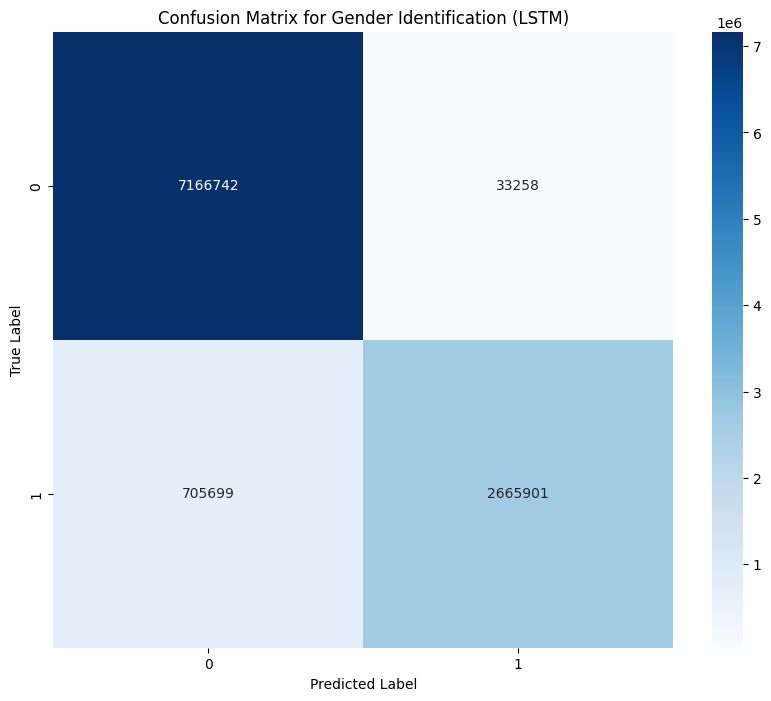

In [32]:
# LSTM for gender
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import shap
import os

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert data to PyTorch tensors and create DataLoader
X_train_gender_tensor = torch.tensor(X_train_gender.values, dtype=torch.float32).unsqueeze(2).to(device)
X_test_gender_tensor = torch.tensor(X_test_gender.values, dtype=torch.float32).unsqueeze(2).to(device)
y_train_gender_tensor = torch.tensor(y_train_gender, dtype=torch.float32).to(device)
y_test_gender_tensor = torch.tensor(y_test_gender, dtype=torch.float32).to(device)

# Split the training data into training and validation sets
train_size = int(0.8 * len(X_train_gender_tensor))
val_size = len(X_train_gender_tensor) - train_size
train_dataset, val_dataset = random_split(TensorDataset(X_train_gender_tensor, y_train_gender_tensor), [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=256*1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256*1024, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_gender_tensor, y_test_gender_tensor), batch_size=256*1024, shuffle=False)

# Define the LSTM model
class LSTMGenderModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMGenderModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

# Model parameters
input_size = 1
hidden_size = 128
num_layers = 2
num_classes = 1

# Instantiate the model, define the loss function and the optimizer
model = LSTMGenderModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Evaluation function
def evaluate_model(model, loader):
    model.eval()
    y_pred = []
    y_true = []
    running_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in tqdm(loader, desc="Evaluating", leave=False):
            outputs = model(X_batch).squeeze()
            preds = (outputs > 0.5).float()
            y_pred.extend(preds.cpu().tolist())
            y_true.extend(y_batch.cpu().tolist())
            loss = criterion(outputs, y_batch)
            running_loss += loss.item()

    # Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    return accuracy, precision, recall, f1, roc_auc, running_loss/len(loader)

# Train the model
num_epochs = 20
best_val_accuracy = 0.0
best_model_path = "best_model_gender_LSTM.pth"

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss/len(train_loader):.4f}')
    
    # Evaluate on validation data
    val_accuracy, val_precision, val_recall, val_f1, val_roc_auc, val_loss = evaluate_model(model, val_loader)
    print(f"Validation - Epoch [{epoch+1}/{num_epochs}] Metrics:")
    print(f"Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}, ROC AUC: {val_roc_auc:.4f}, Loss: {val_loss:.4f}")

    # Save the model if it has the best validation accuracy so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"Model saved with validation accuracy: {best_val_accuracy:.4f}")

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Final evaluation on test data
test_accuracy, test_precision, test_recall, test_f1, test_roc_auc, test_loss = evaluate_model(model, test_loader)
print("\nFinal Test Data Evaluation Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"ROC AUC: {test_roc_auc:.4f}")
print(f"Loss: {test_loss:.4f}")

# Plot confusion matrix
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch).squeeze()
        preds = (outputs > 0.5).float()
        y_pred.extend(preds.cpu().tolist())
        y_true.extend(y_batch.cpu().tolist())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix for Gender Identification (LSTM)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# SHAP analysis (for interpretability)
# Note: SHAP for PyTorch models may require using the DeepExplainer
# explainer = shap.DeepExplainer(model, X_train_gender_tensor)
# shap_values = explainer.shap_values(X_test_gender_tensor)
# shap.summary_plot(shap_values, X_test_gender_tensor, plot_type="bar")


Using device: cuda


Training Epoch 1/20: 100%|██████████| 83/83 [05:02<00:00,  3.65s/it]


Epoch [1/20], Training Loss: 1.0948


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation - Epoch [1/20] Metrics:
Accuracy: 0.6692, Precision: 0.5760, Recall: 0.6692, F1 Score: 0.5889, Loss: 1.0745
Model saved with validation accuracy: 0.6692


Training Epoch 2/20: 100%|██████████| 83/83 [05:03<00:00,  3.66s/it]


Epoch [2/20], Training Loss: 1.0748


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation - Epoch [2/20] Metrics:
Accuracy: 0.6692, Precision: 0.5761, Recall: 0.6692, F1 Score: 0.5889, Loss: 1.0745
Model saved with validation accuracy: 0.6692


Training Epoch 3/20: 100%|██████████| 83/83 [05:04<00:00,  3.66s/it]


Epoch [3/20], Training Loss: 1.0747


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation - Epoch [3/20] Metrics:
Accuracy: 0.6692, Precision: 0.5761, Recall: 0.6692, F1 Score: 0.5889, Loss: 1.0745
Model saved with validation accuracy: 0.6692


Training Epoch 4/20: 100%|██████████| 83/83 [05:03<00:00,  3.66s/it]


Epoch [4/20], Training Loss: 1.0747


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation - Epoch [4/20] Metrics:
Accuracy: 0.6692, Precision: 0.5761, Recall: 0.6692, F1 Score: 0.5889, Loss: 1.0745
Model saved with validation accuracy: 0.6692


Training Epoch 5/20: 100%|██████████| 83/83 [05:03<00:00,  3.65s/it]


Epoch [5/20], Training Loss: 1.0747


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation - Epoch [5/20] Metrics:
Accuracy: 0.6692, Precision: 0.5761, Recall: 0.6692, F1 Score: 0.5889, Loss: 1.0745
Model saved with validation accuracy: 0.6692


Training Epoch 6/20: 100%|██████████| 83/83 [05:03<00:00,  3.65s/it]


Epoch [6/20], Training Loss: 1.0747


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation - Epoch [6/20] Metrics:
Accuracy: 0.6692, Precision: 0.5761, Recall: 0.6692, F1 Score: 0.5889, Loss: 1.0745
Model saved with validation accuracy: 0.6692


Training Epoch 7/20: 100%|██████████| 83/83 [05:03<00:00,  3.65s/it]


Epoch [7/20], Training Loss: 1.0747


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation - Epoch [7/20] Metrics:
Accuracy: 0.6692, Precision: 0.5761, Recall: 0.6692, F1 Score: 0.5889, Loss: 1.0745
Model saved with validation accuracy: 0.6692


Training Epoch 8/20: 100%|██████████| 83/83 [05:02<00:00,  3.65s/it]


Epoch [8/20], Training Loss: 1.0747


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation - Epoch [8/20] Metrics:
Accuracy: 0.6692, Precision: 0.5761, Recall: 0.6692, F1 Score: 0.5889, Loss: 1.0745
Model saved with validation accuracy: 0.6692


Training Epoch 9/20: 100%|██████████| 83/83 [05:03<00:00,  3.65s/it]


Epoch [9/20], Training Loss: 1.0747


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation - Epoch [9/20] Metrics:
Accuracy: 0.6693, Precision: 0.5761, Recall: 0.6693, F1 Score: 0.5889, Loss: 1.0745
Model saved with validation accuracy: 0.6693


Training Epoch 10/20: 100%|██████████| 83/83 [05:03<00:00,  3.66s/it]


Epoch [10/20], Training Loss: 1.0747


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation - Epoch [10/20] Metrics:
Accuracy: 0.6692, Precision: 0.5761, Recall: 0.6692, F1 Score: 0.5889, Loss: 1.0745


Training Epoch 11/20: 100%|██████████| 83/83 [05:04<00:00,  3.66s/it]


Epoch [11/20], Training Loss: 1.0747


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation - Epoch [11/20] Metrics:
Accuracy: 0.6692, Precision: 0.5761, Recall: 0.6692, F1 Score: 0.5889, Loss: 1.0744


Training Epoch 12/20: 100%|██████████| 83/83 [05:03<00:00,  3.65s/it]


Epoch [12/20], Training Loss: 1.0747


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation - Epoch [12/20] Metrics:
Accuracy: 0.6693, Precision: 0.5761, Recall: 0.6693, F1 Score: 0.5889, Loss: 1.0744


Training Epoch 13/20: 100%|██████████| 83/83 [05:02<00:00,  3.65s/it]


Epoch [13/20], Training Loss: 1.0747


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation - Epoch [13/20] Metrics:
Accuracy: 0.6693, Precision: 0.5761, Recall: 0.6693, F1 Score: 0.5889, Loss: 1.0744
Model saved with validation accuracy: 0.6693


Training Epoch 14/20: 100%|██████████| 83/83 [05:03<00:00,  3.66s/it]


Epoch [14/20], Training Loss: 1.0747


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation - Epoch [14/20] Metrics:
Accuracy: 0.6693, Precision: 0.5761, Recall: 0.6693, F1 Score: 0.5889, Loss: 1.0744
Model saved with validation accuracy: 0.6693


Training Epoch 15/20: 100%|██████████| 83/83 [05:05<00:00,  3.68s/it]


Epoch [15/20], Training Loss: 1.0748


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation - Epoch [15/20] Metrics:
Accuracy: 0.6692, Precision: 0.5760, Recall: 0.6692, F1 Score: 0.5889, Loss: 1.0745


Training Epoch 16/20: 100%|██████████| 83/83 [05:03<00:00,  3.65s/it]


Epoch [16/20], Training Loss: 1.0752


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation - Epoch [16/20] Metrics:
Accuracy: 0.6692, Precision: 0.5761, Recall: 0.6692, F1 Score: 0.5889, Loss: 1.0745


Training Epoch 17/20: 100%|██████████| 83/83 [05:03<00:00,  3.66s/it]


Epoch [17/20], Training Loss: 1.0748


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation - Epoch [17/20] Metrics:
Accuracy: 0.6693, Precision: 0.5762, Recall: 0.6693, F1 Score: 0.5890, Loss: 1.0744
Model saved with validation accuracy: 0.6693


Training Epoch 18/20: 100%|██████████| 83/83 [05:03<00:00,  3.66s/it]


Epoch [18/20], Training Loss: 1.0747


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation - Epoch [18/20] Metrics:
Accuracy: 0.6693, Precision: 0.5761, Recall: 0.6693, F1 Score: 0.5890, Loss: 1.0744


Training Epoch 19/20: 100%|██████████| 83/83 [05:04<00:00,  3.66s/it]


Epoch [19/20], Training Loss: 1.0747


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation - Epoch [19/20] Metrics:
Accuracy: 0.6693, Precision: 0.5761, Recall: 0.6693, F1 Score: 0.5890, Loss: 1.0744


Training Epoch 20/20: 100%|██████████| 83/83 [05:03<00:00,  3.66s/it]


Epoch [20/20], Training Loss: 1.0747


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation - Epoch [20/20] Metrics:
Accuracy: 0.6693, Precision: 0.5762, Recall: 0.6693, F1 Score: 0.5890, Loss: 1.0744
Model saved with validation accuracy: 0.6693


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Final Test Data Evaluation Metrics:
Accuracy: 0.9026
Precision: 0.8442
Recall: 0.9026
F1 Score: 0.8674
Loss: 0.8397


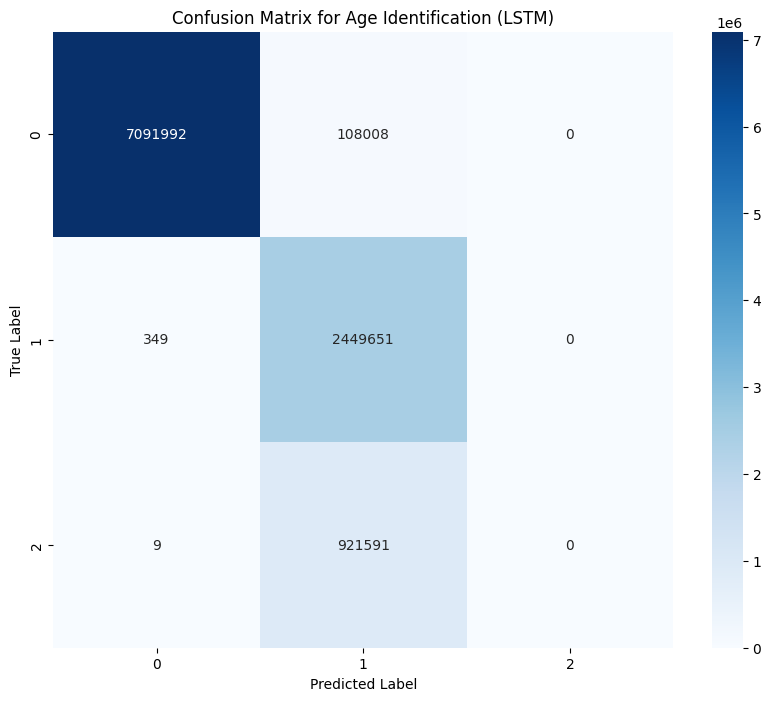

In [33]:
# LSTM for age
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import shap
import os

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert data to PyTorch tensors and create DataLoader
X_train_age_tensor = torch.tensor(X_train_age.values, dtype=torch.float32).unsqueeze(2).to(device)
X_test_age_tensor = torch.tensor(X_test_age.values, dtype=torch.float32).unsqueeze(2).to(device)
y_train_age_tensor = torch.tensor(y_train_age, dtype=torch.long).to(device)  # Use long for CrossEntropyLoss
y_test_age_tensor = torch.tensor(y_test_age, dtype=torch.long).to(device)

# Split the training data into training and validation sets
train_size = int(0.8 * len(X_train_age_tensor))
val_size = len(X_train_age_tensor) - train_size
train_dataset, val_dataset = random_split(TensorDataset(X_train_age_tensor, y_train_age_tensor), [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=256*1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256*1024, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_age_tensor, y_test_age_tensor), batch_size=256*1024, shuffle=False)

# Define the LSTM model
class LSTMAgeModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMAgeModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        return out

# Model parameters
input_size = 1
hidden_size = 128
num_layers = 2
num_classes = len(set(y_train_age))  # Number of unique age bins

# Instantiate the model, define the loss function and the optimizer
model = LSTMAgeModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Evaluation function
def evaluate_model(model, loader):
    model.eval()
    y_pred = []
    y_true = []
    running_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in tqdm(loader, desc="Evaluating", leave=False):
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().tolist())
            y_true.extend(y_batch.cpu().tolist())
            loss = criterion(outputs, y_batch)
            running_loss += loss.item()

    # Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    return accuracy, precision, recall, f1, running_loss/len(loader)

# Train the model
num_epochs = 20
best_val_accuracy = 0.0
best_model_path = "best_model_age_LSTM.pth"

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss/len(train_loader):.4f}')
    
    # Evaluate on validation data
    val_accuracy, val_precision, val_recall, val_f1, val_loss = evaluate_model(model, val_loader)
    print(f"Validation - Epoch [{epoch+1}/{num_epochs}] Metrics:")
    print(f"Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}, Loss: {val_loss:.4f}")

    # Save the model if it has the best validation accuracy so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"Model saved with validation accuracy: {best_val_accuracy:.4f}")

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Final evaluation on test data
test_accuracy, test_precision, test_recall, test_f1, test_loss = evaluate_model(model, test_loader)
print("\nFinal Test Data Evaluation Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Loss: {test_loss:.4f}")

# Plot confusion matrix
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().tolist())
        y_true.extend(y_batch.cpu().tolist())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix for Age Identification (LSTM)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# SHAP analysis (for interpretability)
# Note: SHAP for PyTorch models may require using the DeepExplainer
# explainer = shap.DeepExplainer(model, X_train_age_tensor)
# shap_values = explainer.shap_values(X_test_age_tensor)
# shap.summary_plot(shap_values, X_test_age_tensor, plot_type="bar")


In [4]:
# LSTM for patient ID
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import shap
import os

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Encode participant labels
label_encoder = LabelEncoder()
y_train_id_encoded = label_encoder.fit_transform(y_train_id)
y_test_id_encoded = label_encoder.transform(y_test_id)
num_classes = len(label_encoder.classes_)

# Convert data to PyTorch tensors and create DataLoader
X_train_id_tensor = torch.tensor(X_train_id.values, dtype=torch.float32).unsqueeze(2).to(device)
X_test_id_tensor = torch.tensor(X_test_id.values, dtype=torch.float32).unsqueeze(2).to(device)
y_train_id_tensor = torch.tensor(y_train_id_encoded, dtype=torch.long).to(device)  # Use long for CrossEntropyLoss
y_test_id_tensor = torch.tensor(y_test_id_encoded, dtype=torch.long).to(device)

# Split the training data into training and validation sets
train_size = int(0.8 * len(X_train_id_tensor))
val_size = len(X_train_id_tensor) - train_size
train_dataset, val_dataset = random_split(TensorDataset(X_train_id_tensor, y_train_id_tensor), [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=256*1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256*1024, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_id_tensor, y_test_id_tensor), batch_size=256*1024, shuffle=False)

print(f"Number of unique patient IDs: {num_classes}")

# Define the LSTM model
class LSTMIDModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMIDModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc1(out[:, -1, :])
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out

# Model parameters
input_size = 1
hidden_size = 256
num_layers = 3

# Instantiate the model, define the loss function and the optimizer
model = LSTMIDModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Evaluation function
def evaluate_model(model, loader):
    model.eval()
    y_pred = []
    y_true = []
    running_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in tqdm(loader, desc="Evaluating", leave=False):
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().tolist())
            y_true.extend(y_batch.cpu().tolist())
            loss = criterion(outputs, y_batch)
            running_loss += loss.item()

    # Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    return accuracy, precision, recall, f1, running_loss/len(loader)

# Train the model
num_epochs = 20
best_val_accuracy = 0.0
best_model_path = "best_model_patient_ID_LSTM.pth"

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss/len(train_loader):.4f}')
    
    # Evaluate on validation data
    val_accuracy, val_precision, val_recall, val_f1, val_loss = evaluate_model(model, val_loader)
    print(f"Validation - Epoch [{epoch+1}/{num_epochs}] Metrics:")
    print(f"Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}, Loss: {val_loss:.4f}")

    # Save the model if it has the best validation accuracy so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"Model saved with validation accuracy: {best_val_accuracy:.4f}")

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Final evaluation on test data
test_accuracy, test_precision, test_recall, test_f1, test_loss = evaluate_model(model, test_loader)
print("\nFinal Test Data Evaluation Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Loss: {test_loss:.4f}")

# Plot confusion matrix
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().tolist())
        y_true.extend(y_batch.cpu().tolist())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix for Patient ID Identification (LSTM)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# SHAP analysis (for interpretability)
# Note: SHAP for PyTorch models may require using the DeepExplainer
# explainer = shap.DeepExplainer(model, X_train_id_tensor)
# shap_values = explainer.shap_values(X_test_id_tensor)
# shap.summary_plot(shap_values, X_test_id_tensor, plot_type="bar")


Using device: cuda
Number of unique patient IDs: 23


Training Epoch 1/20: 100%|██████████| 92/92 [08:20<00:00,  5.44s/it]


Epoch [1/20], Training Loss: 2.0282


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation - Epoch [1/20] Metrics:
Accuracy: 0.3253, Precision: 0.2791, Recall: 0.3253, F1 Score: 0.2384, Loss: 1.8406
Model saved with validation accuracy: 0.3253


Training Epoch 2/20:  64%|██████▍   | 59/92 [05:21<03:04,  5.59s/it]

In [ ]:
# RNN for patient ID
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import shap
import os

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Encode participant labels
label_encoder = LabelEncoder()
y_train_id_encoded = label_encoder.fit_transform(y_train_id)
y_test_id_encoded = label_encoder.transform(y_test_id)
num_classes = len(label_encoder.classes_)

# Convert data to PyTorch tensors and create DataLoader
X_train_id_tensor = torch.tensor(X_train_id.values, dtype=torch.float32).unsqueeze(2).to(device)
X_test_id_tensor = torch.tensor(X_test_id.values, dtype=torch.float32).unsqueeze(2).to(device)
y_train_id_tensor = torch.tensor(y_train_id_encoded, dtype=torch.long).to(device)  # Use long for CrossEntropyLoss
y_test_id_tensor = torch.tensor(y_test_id_encoded, dtype=torch.long).to(device)

# Split the training data into training and validation sets
train_size = int(0.8 * len(X_train_id_tensor))
val_size = len(X_train_id_tensor) - train_size
train_dataset, val_dataset = random_split(TensorDataset(X_train_id_tensor, y_train_id_tensor), [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=256*1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256*1024, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_id_tensor, y_test_id_tensor), batch_size=256*1024, shuffle=False)

print(f"Number of unique patient IDs: {num_classes}")

# Define the RNN model
class RNNIDModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNIDModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc1(out[:, -1, :])
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out

# Model parameters
input_size = 1
hidden_size = 256
num_layers = 3

# Instantiate the model, define the loss function and the optimizer
model = RNNIDModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Evaluation function
def evaluate_model(model, loader):
    model.eval()
    y_pred = []
    y_true = []
    running_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in tqdm(loader, desc="Evaluating", leave=False):
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().tolist())
            y_true.extend(y_batch.cpu().tolist())
            loss = criterion(outputs, y_batch)
            running_loss += loss.item()

    # Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    return accuracy, precision, recall, f1, running_loss/len(loader)

# Train the model
num_epochs = 20
best_val_accuracy = 0.0
best_model_path = "best_model_patient_ID_RNN.pth"

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss/len(train_loader):.4f}')
    
    # Evaluate on validation data
    val_accuracy, val_precision, val_recall, val_f1, val_loss = evaluate_model(model, val_loader)
    print(f"Validation - Epoch [{epoch+1}/{num_epochs}] Metrics:")
    print(f"Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}, Loss: {val_loss:.4f}")

    # Save the model if it has the best validation accuracy so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"Model saved with validation accuracy: {best_val_accuracy:.4f}")

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Final evaluation on test data
test_accuracy, test_precision, test_recall, test_f1, test_loss = evaluate_model(model, test_loader)
print("\nFinal Test Data Evaluation Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Loss: {test_loss:.4f}")

# Plot confusion matrix
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().tolist())
        y_true.extend(y_batch.cpu().tolist())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix for Patient ID Identification (RNN)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# SHAP analysis (for interpretability)
# Note: SHAP for PyTorch models may require using the DeepExplainer
# explainer = shap.DeepExplainer(model, X_train_id_tensor)
# shap_values = explainer.shap_values(X_test_id_tensor)
# shap.summary_plot(shap_values, X_test_id_tensor, plot_type="bar")


Using device: cuda
Number of unique patient IDs: 23


Training Epoch 1/50:   0%|          | 0/92 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Autoencoder for patient ID
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import shap
import os

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Encode participant labels
label_encoder = LabelEncoder()
y_train_id_encoded = label_encoder.fit_transform(y_train_id)
y_test_id_encoded = label_encoder.transform(y_test_id)
num_classes = len(label_encoder.classes_)

# Convert data to PyTorch tensors and create DataLoader
X_train_id_tensor = torch.tensor(X_train_id.values, dtype=torch.float32).unsqueeze(2).to(device)
X_test_id_tensor = torch.tensor(X_test_id.values, dtype=torch.float32).unsqueeze(2).to(device)
y_train_id_tensor = torch.tensor(y_train_id_encoded, dtype=torch.long).to(device)  # Use long for CrossEntropyLoss
y_test_id_tensor = torch.tensor(y_test_id_encoded, dtype=torch.long).to(device)

# Split the training data into training and validation sets
train_size = int(0.8 * len(X_train_id_tensor))
val_size = len(X_train_id_tensor) - train_size
train_dataset, val_dataset = random_split(TensorDataset(X_train_id_tensor, y_train_id_tensor), [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=256*1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256*1024, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_id_tensor, y_test_id_tensor), batch_size=256*1024, shuffle=False)

print(f"Number of unique patient IDs: {num_classes}")

# Define the Autoencoder model
class AutoencoderIDModel(nn.Module):
    def __init__(self, input_size, hidden_size, code_size, num_classes):
        super(AutoencoderIDModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, code_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(code_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )
        self.classifier = nn.Linear(code_size, num_classes)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        classified = self.classifier(encoded)
        return classified, decoded

# Model parameters
input_size = X_train_id_tensor.shape[1]
hidden_size = 128
code_size = 64

# Instantiate the model, define the loss function and the optimizer
model = AutoencoderIDModel(input_size, hidden_size, code_size, num_classes).to(device)
criterion_classifier = nn.CrossEntropyLoss()
criterion_autoencoder = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Evaluation function
def evaluate_model(model, loader):
    model.eval()
    y_pred = []
    y_true = []
    running_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in tqdm(loader, desc="Evaluating", leave=False):
            outputs, _ = model(X_batch)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().tolist())
            y_true.extend(y_batch.cpu().tolist())
            loss = criterion_classifier(outputs, y_batch)
            running_loss += loss.item()

    # Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    return accuracy, precision, recall, f1, running_loss/len(loader)

# Train the model
num_epochs = 20
best_val_accuracy = 0.0
best_model_path = "best_model_patient_ID_Autoencoder.pth"

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        outputs, decoded = model(X_batch)
        loss_classifier = criterion_classifier(outputs, y_batch)
        loss_autoencoder = criterion_autoencoder(decoded, X_batch)
        loss = loss_classifier + loss_autoencoder
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss/len(train_loader):.4f}')
    
    # Evaluate on validation data
    val_accuracy, val_precision, val_recall, val_f1, val_loss = evaluate_model(model, val_loader)
    print(f"Validation - Epoch [{epoch+1}/{num_epochs}] Metrics:")
    print(f"Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}, Loss: {val_loss:.4f}")

    # Save the model if it has the best validation accuracy so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"Model saved with validation accuracy: {best_val_accuracy:.4f}")

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Final evaluation on test data
test_accuracy, test_precision, test_recall, test_f1, test_loss = evaluate_model(model, test_loader)
print("\nFinal Test Data Evaluation Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Loss: {test_loss:.4f}")

# Plot confusion matrix
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs, _ = model(X_batch)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().tolist())
        y_true.extend(y_batch.cpu().tolist())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix for Patient ID Identification (Autoencoder)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# SHAP analysis (for interpretability)
# Note: SHAP for PyTorch models may require using the DeepExplainer
# explainer = shap.DeepExplainer(model, X_train_id_tensor)
# shap_values = explainer.shap_values(X_test_id_tensor)
# shap.summary_plot(shap_values, X_test_id_tensor, plot_type="bar")


In [ ]:
# Transformer for patient ID
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import shap
import os

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Encode participant labels
label_encoder = LabelEncoder()
y_train_id_encoded = label_encoder.fit_transform(y_train_id)
y_test_id_encoded = label_encoder.transform(y_test_id)
num_classes = len(label_encoder.classes_)

# Convert data to PyTorch tensors and create DataLoader
X_train_id_tensor = torch.tensor(X_train_id.values, dtype=torch.float32).unsqueeze(2).to(device)
X_test_id_tensor = torch.tensor(X_test_id.values, dtype=torch.float32).unsqueeze(2).to(device)
y_train_id_tensor = torch.tensor(y_train_id_encoded, dtype=torch.long).to(device)  # Use long for CrossEntropyLoss
y_test_id_tensor = torch.tensor(y_test_id_encoded, dtype=torch.long).to(device)

# Split the training data into training and validation sets
train_size = int(0.8 * len(X_train_id_tensor))
val_size = len(X_train_id_tensor) - train_size
train_dataset, val_dataset = random_split(TensorDataset(X_train_id_tensor, y_train_id_tensor), [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=256*1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256*1024, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_id_tensor, y_test_id_tensor), batch_size=256*1024, shuffle=False)

print(f"Number of unique patient IDs: {num_classes}")

# Define the Transformer model
class TransformerIDModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, nhead=8, dim_feedforward=512, dropout=0.3):
        super(TransformerIDModel, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_size)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        x = self.fc1(x[:, -1, :])
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Model parameters
input_size = 1
hidden_size = 256
num_layers = 3

# Instantiate the model, define the loss function and the optimizer
model = TransformerIDModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Evaluation function
def evaluate_model(model, loader):
    model.eval()
    y_pred = []
    y_true = []
    running_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in tqdm(loader, desc="Evaluating", leave=False):
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().tolist())
            y_true.extend(y_batch.cpu().tolist())
            loss = criterion(outputs, y_batch)
            running_loss += loss.item()

    # Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    return accuracy, precision, recall, f1, running_loss/len(loader)

# Train the model
num_epochs = 20
best_val_accuracy = 0.0
best_model_path = "best_model_patient_ID_Transformer.pth"

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss/len(train_loader):.4f}')
    
    # Evaluate on validation data
    val_accuracy, val_precision, val_recall, val_f1, val_loss = evaluate_model(model, val_loader)
    print(f"Validation - Epoch [{epoch+1}/{num_epochs}] Metrics:")
    print(f"Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}, Loss: {val_loss:.4f}")

    # Save the model if it has the best validation accuracy so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"Model saved with validation accuracy: {best_val_accuracy:.4f}")

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Final evaluation on test data
test_accuracy, test_precision, test_recall, test_f1, test_loss = evaluate_model(model, test_loader)
print("\nFinal Test Data Evaluation Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Loss: {test_loss:.4f}")

# Plot confusion matrix
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().tolist())
        y_true.extend(y_batch.cpu().tolist())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix for Patient ID Identification (Transformer)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# SHAP analysis (for interpretability)
# Note: SHAP for PyTorch models may require using the DeepExplainer
# explainer = shap.DeepExplainer(model, X_train_id_tensor)
# shap_values = explainer.shap_values(X_test_id_tensor)
# shap.summary_plot(shap_values, X_test_id_tensor, plot_type="bar")
